In [1]:
from datetime import date

print("Last run date:", date.today())

Last run date: 2023-03-14


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import stats
import os
import matplotlib
import math
import seaborn as sns

import lib.minibulk_funcs as mb
import lib.figs_funcs as figfunc
import lib.matx_funcs as matxfunc
import lib.fun_plotting as fun_plotting

import lib.NetAnalysis as na
import lib.funcs_ko as funcs_ko

%load_ext autoreload
%autoreload 2

In [3]:
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rc('text', usetex=True)

In [4]:
import os
current_path = os.getcwd()
current_path

'/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/GRN_Inference_CODE'

In [5]:
path = "/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/" # for Mac
path_data = path+"DATA/"

In [6]:
imp_genes = np.loadtxt(path_data+"general_info/imp_genes.csv", dtype="str")
imp_genes

array(['Klf4', 'Klf2', 'Esrrb', 'Tfcp2l1', 'Tbx3', 'Stat3', 'Tcf7l1',
       'Nanog', 'Sall4', 'Pou5f1', 'Sox2', 'Dnmt3a', 'Dnmt3b', 'Utf1',
       'Otx2', 'Etv5', 'Etv4', 'Nr0b1', 'Zic3', 'Lef1', 'Tcf15', 'Gbx2',
       'Pou3f1', 'Rbpj'], dtype='<U7')

In [7]:
data_type = "raw" # Or  "PsiNorm"
important_genes = True

if important_genes == True:
    text = "imp_genes_"+data_type
else:
    text = data_type
        
print(text)

imp_genes_raw


In [8]:
# GENE CLASSIFICATION
naive = ["Klf4", "Klf2", "Esrrb", "Tfcp2l1", "Tbx3", "Stat3", "Nanog", "Sox2"]
formative = ["Nr0b1", "Zic3", "Rbpj", "Utf1", "Etv4", "Tcf15"]
committed = ["Dnmt3a", "Dnmt3b", "Lef1", "Otx2", "Pou3f1", "Etv5"]

genes_order = np.concatenate((naive, formative, committed))
nc_genes = np.setdiff1d(imp_genes, genes_order)
genes_order = np.concatenate((genes_order, nc_genes))

Fissiamo la threshold per calcolare il Mini-bulk

In [9]:
w_size = 150


# Check on Knrown interactions

In [10]:
def TP_check(interaction_list, interaction_matrix, genes_list, inferred_int_thr = 0, Norm = True):
    """
    NOTE: for not symmetric interaction_matrix:
    - rows: who undergoes the action;
    -columns: who acts.
    NOTE: to read the input interaction_list:
    - couple[0] : who acts;
    - couple[1] : who undergoes the action.
    
    NOTE: inferred_int_thr is computed as fraction of max(interaction_matrix) 
    """
    if Norm:
        m_max = np.max(np.abs(interaction_matrix))
    else:
        m_max = 1
    
    true_positive=0
    int_val = np.zeros(len(interaction_list))
    wrong_ints = []
    out_matx = np.zeros((4, len(interaction_list)))
    
    for ii in range(len(interaction_list)): # split the list of strings
        couple = interaction_list[ii].split(" ")
        gene1_idx = np.where(genes_list == couple[1])[0] #idx of gene 1
        gene0_idx = np.where(genes_list == couple[0])[0] #idx of gene 0  
        
        # check if the interaction's genes already exist:
        if (len(np.where(genes_list == couple[0])[0])==0):
            print("Gene "+ couple[0]+" not found")
            continue
        if (len(np.where(genes_list == couple[1])[0])==0):
            print("Gene "+ couple[1]+" not found")
            continue
            
        # the subjects of the interaction
        out_matx[0,ii] = gene0_idx # who acts
        out_matx[1,ii] = gene1_idx # who acts
  
        # the interaction value (and the sign of the interaction)
        out_matx[2,ii] = interaction_matrix[gene1_idx[0], gene0_idx[0]]
        interaction = np.sign(out_matx[2,ii])

        if (interaction==int(couple[2])) and (np.abs(out_matx[2,ii])/m_max >= inferred_int_thr):
            out_matx[3,ii] = 1
        else:
            out_matx[3,ii] = 0

    return(np.sum(out_matx[3,:])/len(out_matx[3,:]), out_matx)
        

In [11]:
def TP_plot(interaction_list, interaction_matrix, genes_order, inferred_int_thr=0, Norm_Matx = False,
            data_type="scRNA-seq PST MB", 
            figplot=True, nbin=30, 
            verbose=False, Norm=True):
    """Wrap function to visualize all the results of the comparison with the known interactions (TP)"""
    
    if Norm_Matx:
        interaction_matrix= interaction_matrix/np.nanmax(np.abs(interaction_matrix))

    # Check the list of known interactions correctly inferred
    TP_fraction, TP_info = TP_check(interaction_list, interaction_matrix, genes_order, inferred_int_thr, Norm=Norm)
    
    # Print the fraction of true positives and the TP and all interaction values:
    if verbose==True:
        print("\nRESULTS for " + data_type)
        print("\nTP fraction:", np.round(TP_fraction, 2))
        print("\nInteraction values:\n", np.round(TP_info[2,:],3))
        print("\nTP ints values:\n", np.round(TP_info[2,:]*TP_info[3,:],3))
    
    # If the figplot flag is set to True, plot the matrix and the distribution of the INTERACTION MATRIX
    if figplot==True:
        bins = np.linspace(interaction_matrix.flatten().min(), interaction_matrix.flatten().max(), nbin)
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
        figfunc.plotmat(interaction_matrix, fig, ax[0], genes_order, data_type+"")
        sns.histplot(np.ndarray.flatten(interaction_matrix), ax=ax[1], stat="density", bins=bins)
        plt.show()
        
    return(TP_fraction, TP_info, interaction_matrix)


## Neighbours interactions

In [12]:
TPtrial_list = ["Stat3 Klf4 1", "Nanog Esrrb 1", "Stat3 Dnmt3b -1", 
                "Nanog Otx2 -1", "Nanog Pou3f1 -1",
                "Stat3 Gbx2 1", "Stat3 Tfcp2l1 1", # "Stat3 Stat3 1"
                "Otx2 Pou3f1 1", "Otx2 Dnmt3a 1", 
                "Tcf7l1 Esrrb -1", "Tcf7l1 Klf2 -1", "Tcf7l1 Nanog -1", "Tcf7l1 Nr0b1 -1",  "Tcf7l1 Tfcp2l1 -1",  
                "Rbpj Nanog -1", "Rbpj Tbx3 -1", "Etv5 Lef1 1", "Etv5 Pou3f1 1"]


## Directed correlations

In [13]:
df_KO_N24_Leeb_cl = pd.read_csv(path_data+'Leeb_Data_Orig/df_KO_N24_cleaned.csv', index_col=0, header=0)

# SCODE

In [14]:
# data_PST = pd.read_csv("~/Downloads/SCODE-master/MyData/timePST.txt", sep="\t", header=None)

# data_LN = pd.read_csv("~/Downloads/SCODE-master/MyData/data_LN.txt", sep="\t", header=None)

# data_PST.shape
# data_LN.shape

In [15]:
df_lN = pd.read_csv(path_data + "GE_data/imp_genes_logNorm.csv", header=0, index_col=0, sep=",").reindex(genes_order)
df_lN.head(3)



,AAACCCAGTGACCGTC,AAACGAAAGCGCGTTC,AAACGAACAAGCACCC,AAACGAATCAAGTCGT,AAACGCTTCCGTGACG,AAAGAACGTCAGATTC,AAAGAACTCACTTGTT,AAAGGATCAAATCAAG,AAAGGATTCTGAACGT,AAAGGGCAGCAGGCAT,...,TTTGACTGTCAGCTTA,TTTGACTGTGTTATCG,TTTGACTTCGCCACTT,TTTGATCGTTCTCCAC,TTTGGTTAGAGAGCGG,TTTGGTTGTGATCATC,TTTGGTTTCACGGGCT,TTTGGTTTCCAACACA,TTTGTTGCATCGAAGG,TTTGTTGCATCTCATT
1.1,,,,,,,,,,,,,,,,,,,,,
Klf4,1.624017,1.427111,0.000000,0.843545,2.582635,1.825359,0.000000,1.162685,1.708780,0.000000,...,0.0,1.628406,1.075557,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
Klf2,1.624017,0.000000,1.436316,1.372344,0.000000,1.430803,2.483172,2.237629,1.093845,1.716736,...,0.0,2.048784,1.075557,0.0,0.0,0.0,2.317913,0.000000,0.0,1.692006
Esrrb,0.000000,1.427111,0.000000,1.372344,1.413292,0.000000,0.000000,1.162685,0.000000,0.000000,...,0.0,1.032705,0.000000,0.0,0.0,0.0,1.219525,0.960339,0.0,0.000000


## PST

,barcodes,time,pst
3696,CGGGACTTCGGCTCTT,00h,0.0
89,AAAGTGACAGGTGGAT,00h,0.0
4382,CTGTACCTCCGCACTT,00h,0.0


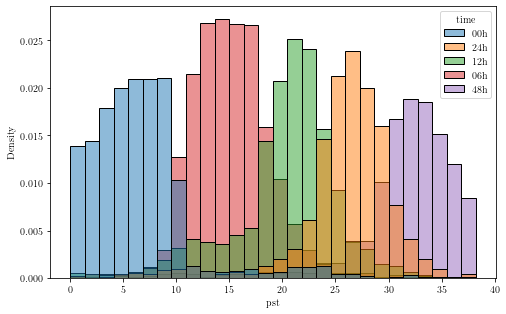

In [16]:
pst_df = pd.read_csv(path_data+'input_data/cellinfo_pseudotime_3no2CLC_22_09_22.txt',
                              header = 0, sep = ' ', quotechar = '"', 
                              names = ["barcodes", "time", "pst"])



#riordino
pst_df = pst_df.sort_values(by=['pst'])

#plot different times
plt.figure(figsize=(8,5))
sns.histplot(data=pst_df, x="pst", hue="time", stat="density")

column_names = pst_df["barcodes"]

pst_df.head(3)

In [17]:
mb_wind=150
# riordino dataframe 
df_lN_pst = df_lN.reindex(columns = column_names)

df_lN_mb_pst = df_lN_pst.rolling(window=mb_wind, axis=1).mean().dropna(axis=1)
df_lN_mb_pst = pd.DataFrame(df_lN_mb_pst, index=df_lN_pst.index)

df_lN_mb_pst.head(3)



barcodes,GGCGTCAGTCAACGCC,CTCATGCGTCAGGTAG,CTGCCATAGACCGCCT,AGCCAATCAAATCAGA,CGGGTCATCTGGAGAG,TCATTTGTCATCGGGC,AGCATCAAGTACTGGG,ATTCAGGTCGGTTAGT,TCGATTTTCAATCCGA,TATCCTACATAGGTTC,...,TTTGACTTCGCCACTT,GCCATTCTCATTCACT,GAAACCTGTTGTGCCG,CAACCAAAGCCTCACG,TCCTCTTTCGTCCATC,CTAACCCCACAATGCT,CCACACTCACACCAGC,CACGTTCAGCCGAACA,TGATTCTTCCGTTTCG,CTTGATTCACCATTCC
1.1,,,,,,,,,,,,,,,,,,,,,
Klf4,1.237182,1.233101,1.243267,1.243267,1.258404,1.267722,1.283406,1.280832,1.280832,1.278514,...,0.219237,0.219237,0.219237,0.219237,0.219237,0.219237,0.219237,0.219237,0.228717,0.228717
Klf2,1.143295,1.152089,1.142363,1.142363,1.148623,1.156669,1.146918,1.144345,1.160804,1.173730,...,0.603555,0.594118,0.579160,0.579160,0.567149,0.567149,0.561093,0.561093,0.547104,0.538954
Esrrb,0.279826,0.288620,0.294988,0.287320,0.273908,0.284033,0.296715,0.296715,0.296715,0.296715,...,0.227777,0.227777,0.227777,0.227777,0.227777,0.235784,0.235784,0.244157,0.250020,0.250020


### Initial vector for SIMULATION

In [18]:
df_lN_mb_pst.iloc[:,:1500].mean(axis=1)


# Creating a column of integers from 0 to the length of the series
df_saving_index = pd.DataFrame(range(len(genes_order))).set_index(genes_order)

# concatenating the series and the index
result = pd.concat([df_saving_index, df_lN_mb_pst.iloc[:,:1000].mean(axis=1)], axis=1)
result
# Saving the resulting DataFrame as a tab-separated text file named 'result.txt'
result.to_csv(path_data+"OUT_SCODE_LN/initial_GE_LogNorm_MB.txt", sep='\t', index=False, header=False)


In [19]:
data_LN = df_lN_mb_pst.copy()
data_LN.columns = np.arange(0,len(data_LN.columns))
data_LN.index = np.arange(0,len(data_LN.index))

data_LN.head(3)

,0,1,2,3,4,5,6,7,8,9,...,9537,9538,9539,9540,9541,9542,9543,9544,9545,9546
0,1.237182,1.233101,1.243267,1.243267,1.258404,1.267722,1.283406,1.280832,1.280832,1.278514,...,0.219237,0.219237,0.219237,0.219237,0.219237,0.219237,0.219237,0.219237,0.228717,0.228717
1,1.143295,1.152089,1.142363,1.142363,1.148623,1.156669,1.146918,1.144345,1.160804,1.173730,...,0.603555,0.594118,0.579160,0.579160,0.567149,0.567149,0.561093,0.561093,0.547104,0.538954
2,0.279826,0.288620,0.294988,0.287320,0.273908,0.284033,0.296715,0.296715,0.296715,0.296715,...,0.227777,0.227777,0.227777,0.227777,0.227777,0.235784,0.235784,0.244157,0.250020,0.250020


In [20]:
data_PST= pst_df.replace("00h", int(0)).replace("06h", int(6)).replace("12h", int(12)).replace("24h", int(24)).replace("48h", int(48))
data_PST = data_PST.iloc[:,1:] #remove Barcodes

#normalize pst between 0 and 1
data_PST["pst"]=data_PST["pst"]/(data_PST["pst"].max())

# rolling average
data_PST = data_PST.rolling(window=mb_wind, axis=0).mean().dropna(axis=0)
data_PST["time"] = data_PST["time"].astype('int')

# rename indices
data_PST.index = np.arange(0,len(data_PST.index))
print(data_PST.shape)
data_PST.tail(5)


(9547, 2)


,time,pst
9542,46,0.977177
9543,46,0.977482
9544,46,0.977785
9545,46,0.978089
9546,46,0.978392


## Check on RSS (100 trials)

In [21]:
# Train and Test
training_data = data_LN.sample(frac=0.8, random_state=2407, replace=False, axis=1)
testing_data  = data_LN.drop(training_data.columns, axis=1)

training_time = data_PST.loc[training_data.columns, :]
testing_time  = data_PST.drop(training_data.columns, axis=0)

# print(training_data.shape[1]+testing_data.shape[1])
print(training_data.shape, testing_data.shape)
print(training_time.shape, testing_time.shape)


(24, 7638) (24, 1909)
(7638, 2) (1909, 2)


In [22]:
# print(training_data.isnull().sum().sum())
# print(testing_data.isnull().sum().sum())
# print(training_time.isnull().sum().sum())
# print(testing_time.isnull().sum().sum())

In [23]:
to_save=False
if to_save==True:
    training_data.to_csv(r'IN_SCODE/PST_MB/train_data.txt', header=None, index=None, sep='\t', mode='w')
    training_time.to_csv(r'IN_SCODE/PST_MB/train_time.txt', header=None, index=None, sep='\t', mode='w')

    testing_data.to_csv(r'IN_SCODE/PST_MB/test_data.txt', header=None, index=None, sep='\t', mode='w')
    testing_time.to_csv(r'IN_SCODE/PST_MB/test_time.txt', header=None, index=None, sep='\t', mode='w')

# Matrices computation

In [24]:
# # path1 =  path+"1_NetworkInference/"

# # Train part with more executions
# genes = 24
# D = [2,3,4,6,8]
# cells_train = 7638
# cells_test = 1909
# iters = 100
# data_GE  = training_data
# data_PST = training_time
# Nexp=100

# for jj in range(len(D)):
#     print("D: ", D[jj])
#     for ii in range(Nexp):
#         print("Exp ", ii)
#         out="OUT_SCODE/PST_MB/out_z"+str(D[jj])+"/exp_"+str(ii)
# #         if not os.path.isdir(out):
# #             os.makedirs(out)
#         out_file = "OUT_SCODE/PST_MB/out_z"+str(D[jj])+"/exp_"+str(ii)+"/RSS_test.txt"
#         # Train
#         ! Rscript ~/Downloads/SCODE-master/SCODE.R /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/Code/Work/1_NetworkInference/IN_SCODE/PST_MB/train_data.txt /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/Code/Work/1_NetworkInference/IN_SCODE/PST_MB/train_time.txt {out} {genes} {D[jj]} {cells_train} {iters}
#         # Test
#         ! Rscript ~/Downloads/SCODE-master/RSS.R /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/Code/Work/1_NetworkInference/IN_SCODE/PST_MB/test_data.txt /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/Code/Work/1_NetworkInference/IN_SCODE/PST_MB/test_time.txt {out} {out_file} {genes} {D[jj]} {cells_test}
        


# From Here to not recompute ALL

In [25]:
# Compute D quantile
genes = 24
D = [2,3,4,6,8]
cells_train = 7638
cells_test = 1909
iters = 100
data_GE  = training_data
data_PST = training_time
Nexp=100

RSS_vect = np.zeros((len(D), Nexp))
RSS_quantile = np.zeros((3,len(D)))

# TP_vect = np.zeros((len(D),Nexp))
# TP_max = np.zeros(len(D))
# A_tot = np.zeros((genes, genes, len(D)))
# A_mean = np.zeros((genes, genes, len(D)))
A_sample = np.zeros((genes, genes, len(D), Nexp))
for jj in range(len(D)):
    print("D: ", D[jj])
    for ii in range(Nexp):
        out=       path_data+"OUT_SCODE_LN/PST_MB/out_z"+str(D[jj])+"/exp_"+str(ii)
        out_file = path_data+"OUT_SCODE_LN/PST_MB/out_z"+str(D[jj])+"/exp_"+str(ii)+"/RSS_test.txt"
        RSS_vect[jj,ii] = np.array(pd.read_csv(out_file, sep="\t", header=None))
#         print(D[jj], ii, RSS_vect[jj,ii])
        A_sample[:,:,jj,ii] = pd.read_csv(out+"/A.txt", sep="\t", header=None)
#         A_tot[:,:,jj] += locals()["A"+str(ii)]
#     A_mean = A_tot[:,:,jj]/Nexp
        
    RSS_quantile[:,jj] = np.array([np.quantile(RSS_vect[jj,:], 0.25), np.quantile(RSS_vect[jj,:], 0.5), np.quantile(RSS_vect[jj,:], 0.75)])
#     TP_max[jj] = TP_vect[jj,:].max()



D:  2
D:  3
D:  4
D:  6
D:  8


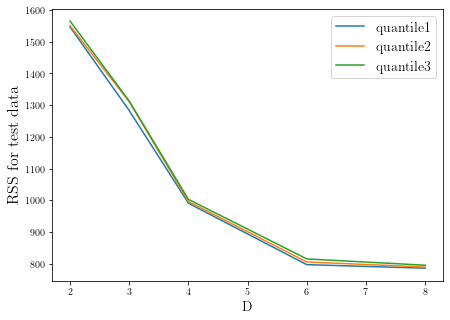

In [26]:
plt.figure(figsize=(7,5))
for ii in range(RSS_quantile.shape[0]):
    plt.plot(D, RSS_quantile[ii,:], label="quantile"+str(ii+1))
    plt.legend(fontsize=14)
    plt.ylabel("RSS for test data", fontsize=16)
    plt.xlabel("D", fontsize=14)    

In [27]:
# Per OGNI D: Devo riordinare in ordine crescente di RSS e poi prendere i 50 RSS più piccoli
A_sel = np.zeros((genes, genes, len(D), 50))
A_lin = np.zeros((genes*genes, len(D), 50))

for jj in range(len(D)):
    idx = np.argsort(RSS_vect[jj,:])[:50]  
    for ii in range(len(idx)):
        A_sel[:,:,jj,ii] = A_sample[:,:,jj,idx[ii]]
        A_lin[:,jj,ii] = A_sample[:,:,jj,idx[ii]].flatten()
        
    


In [28]:
A_lin.shape

(576, 5, 50)

In [29]:

A_quantile = np.zeros((3,len(D)))
for jj in range(len(D)):
    A_exp_corr = np.corrcoef(A_lin[:,jj,:].T)
#     print(np.quantile(A_exp_corr, 0.25))
    A_quantile[:,jj] = np.array([np.quantile(A_exp_corr, 0.25), np.quantile(A_exp_corr, 0.5), np.quantile(A_exp_corr, 0.75)])


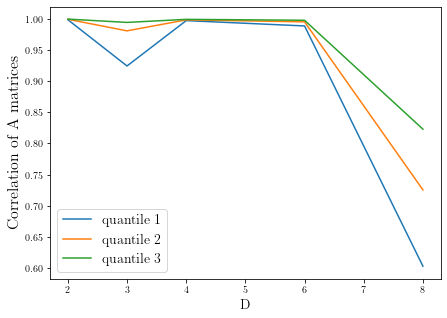

In [30]:
plt.figure(figsize=(7,5))
for ii in range(A_quantile.shape[0]):
    plt.plot(D, A_quantile[ii,:], label="quantile "+str(ii+1))
    plt.legend(fontsize=14)
    plt.ylabel("Correlation of A matrices", fontsize=16)
    plt.xlabel("D", fontsize=14) 

# Interaction Matrix for D=6

## Thr=0.01

thr= 0.01
D= 6


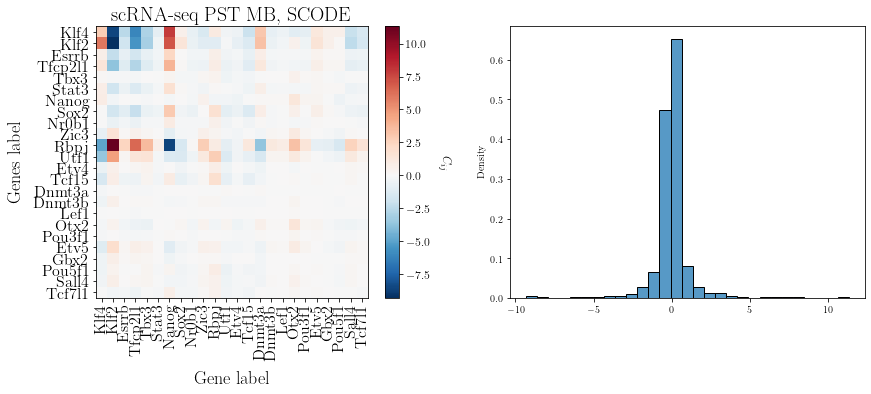

TP fraction  0.3333333333333333
Not Normalized TRUE interactions [-0.    2.38 -0.   -0.    0.    0.   -0.    0.3  -0.   -0.42 -1.53 -0.
 -0.   -0.66 -0.28  0.    0.    0.  ]
Normalized TRUE interactions [-0.    0.21 -0.   -0.    0.    0.   -0.    0.03 -0.   -0.04 -0.14 -0.
 -0.   -0.06 -0.03  0.    0.    0.  ]
Not Normalized interactions [-0.83  2.38 -0.01 -0.03  0.14  0.01 -0.41  0.3  -0.06 -0.42 -1.53 -0.1
 -0.11 -0.66 -0.28  0.41  0.04  0.09]
Normalized interactions [-0.07  0.21 -0.   -0.    0.01  0.   -0.04  0.03 -0.01 -0.04 -0.14 -0.01
 -0.01 -0.06 -0.03  0.04  0.    0.01]


In [31]:
sel_thr = 0.01
print("thr=", sel_thr)

DD = 3
print("D=", D[DD])
N_sel_A = 100
A_tot = np.sum(A_sel[:,:,DD,:N_sel_A], axis=2 )/N_sel_A

TP_fraction, TP_info, interaction_matrix = TP_plot(TPtrial_list, A_tot, genes_order, inferred_int_thr=sel_thr, 
                                                   Norm_Matx = False, data_type="scRNA-seq PST MB, SCODE",
                                                   figplot=True, nbin=30, 
                                                    verbose=False, Norm=True)
                                        
                                                   
                                                    
print("TP fraction ", TP_fraction)

print("Not Normalized TRUE interactions", np.round(TP_info[2,:]*TP_info[3,:],2))
print("Normalized TRUE interactions", np.round(TP_info[2,:]*TP_info[3,:]/np.max(np.abs(A_tot)), 2))

print("Not Normalized interactions", np.round(TP_info[2,:],2))
print("Normalized interactions", np.round(TP_info[2,:]/np.max(np.abs(A_tot)), 2))


# TP_fraction2, TP_info2, _ = TP_plot(Interactions_list, A_tot, genes_order, 
#                                    inferred_int_thr = sel_thr, Norm_Matx = False,
#                                    data_type=" Best model for BULK data",
#                                    figplot=False, verbose=False, nbin=30, Norm = True)
# print("\n\n2nd set of interactions, TPfrac:")
# print(f"{TP_fraction2:.2f}")




### Fraction of discarded

In [32]:
high_meanMatx_thr = na.to_thr_matrix(A_tot, thr=sel_thr)
print(1-(len(np.where(high_meanMatx_thr==0)[0]))/(24**2))
print(len(np.where(A_tot==0)[0]))

0.6579861111111112
0


### Save Interaction Matrix

In [33]:
np.savetxt(path_data+"OUT_SCODE_LN/A_sel_LogNorm_MB.txt",A_tot)

# Simulated

In [34]:
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rc('text', usetex=True)

In [35]:
compute = False
N_sim=500
df_sim = np.zeros((len(genes_order), 101, N_sim))

for ii in range(N_sim):
    if ii%50==0:
        print("Exp ", ii)
    out_sim = "/Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_LN/KO_LN/NO_KO/out_simSCODE_LogNorm_MB_"+str(ii)+".txt"

    if compute:
        # call R script Reconstruct_dynamics.R
        ! Rscript /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/GRN_Inference_CODE/Reconstruct_dynamics.R /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_LN/initial_GE_LogNorm_MB.txt /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_LN/A_sel_LogNorm_MB.txt {out_sim} {24}

    # load simulated data
    df_sim[:,:,ii] = pd.read_table(path_data+"OUT_SCODE_LN/KO_LN/NO_KO/out_simSCODE_LogNorm_MB_"+str(ii)+".txt", delimiter="\t", dtype={"Value": float}).set_index(genes_order)
    df_sim[df_sim<0]=0
    

Exp  0
Exp  50
Exp  100
Exp  150
Exp  200
Exp  250
Exp  300
Exp  350
Exp  400
Exp  450


In [36]:
# average simulated WT
df_sim_avg, df_sim_std = funcs_ko.WT_avg_w(df_sim)
df_sim_std = (df_sim.std(axis=1)/np.sqrt(df_sim.shape[1]))[:,0]

# average exp WT
df_avg = data_LN.mean(axis=1)
df_std = data_LN.std(axis=1)/np.sqrt(data_LN.shape[1])

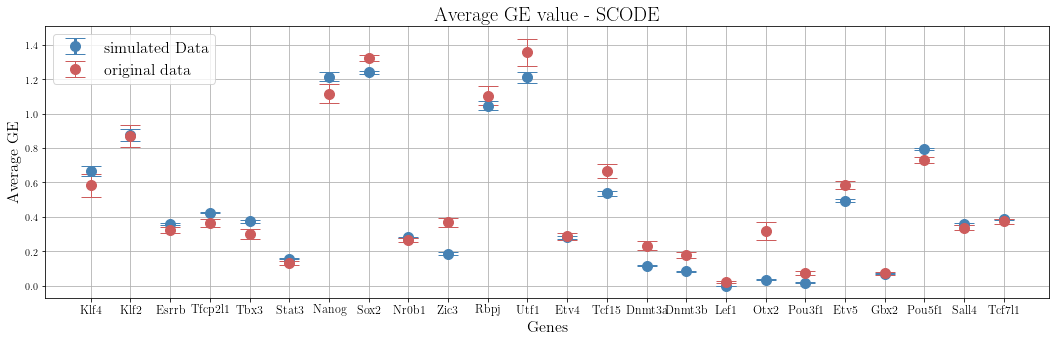

In [37]:
plt.figure(figsize=(18,5))
plt.errorbar(genes_order, df_sim_avg, yerr=df_sim_std,  
             alpha=1, 
             fmt="o", ms = 10,
             elinewidth=3,
             color="steelblue",
             capsize=10,
             label= "simulated Data")

plt.errorbar(genes_order, data_LN.mean(axis=1), yerr=data_LN.std(axis=1)/np.sqrt(24), 
             alpha=1, 
             fmt="o", ms = 10,
             elinewidth=1,
             color="indianred",
             capsize=10,
             label = "original data")
plt.legend(loc="upper left", fontsize=16)
plt.xticks(fontsize=12)
plt.ylabel("Average GE", fontsize=16)
plt.xlabel("Genes", fontsize=16)
plt.title("Average GE value - SCODE", fontsize=20)
plt.grid(True)

gene:  Klf4  has a difference of:  0.08159286341215932  std:  0.08585654477743242
gene:  Klf2  has a difference of:  0.005226139936967522  std:  0.10147198726733295
gene:  Rbpj  has a difference of:  0.057631082864159744  std:  0.0747198346922808
gene:  Etv4  has a difference of:  0.006508928029526906  std:  0.023528578681697644
gene:  Gbx2  has a difference of:  0.0010544107473216824  std:  0.005526668066390983
fraction of significant 0.20833333333333334


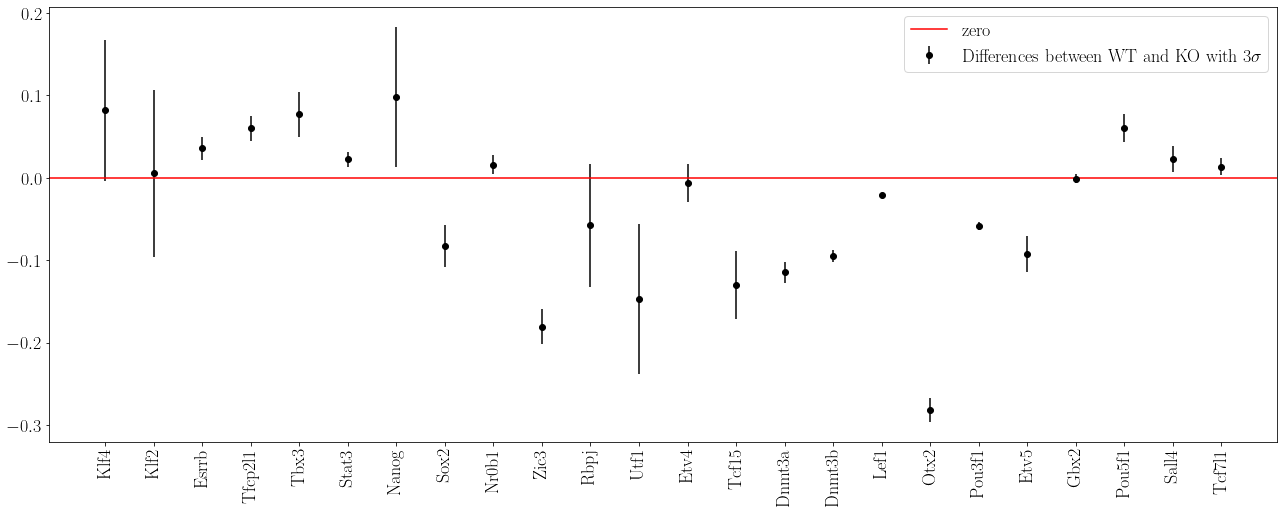

In [38]:
# number of sigma considered
N_sigma = 3

# compute the difference between the original and simulated spins values
diff_activity_lN = np.zeros(len(genes_order))
diff_activity_lN_std = np.zeros(len(genes_order))
count = 0
for i in range(len(genes_order)):
    diff_activity_lN[i] = (df_sim_avg[i] - df_avg[i])
    diff_activity_lN_std[i] = np.sqrt(df_sim_std[i]**2 + df_std[i]**2)
    if np.abs(diff_activity_lN[i]) < N_sigma * diff_activity_lN_std[i]:
        print("gene: ", genes_order[i], " has a difference of: ", np.abs(diff_activity_lN[i]), " std: ", N_sigma * diff_activity_lN_std[i])
        count += 1

plt.figure(figsize=(22,8))
plt.errorbar(genes_order, diff_activity_lN, yerr=N_sigma*diff_activity_lN_std, fmt='o', color='black', label = "Differences between WT and KO with "+str(N_sigma)+"$\sigma$")
plt.axhline(y=0, color='r', linestyle='-', label= " zero")
plt.legend(fontsize=18, loc="upper right")
plt.xticks(rotation=90, fontsize=18)
plt.yticks(fontsize=18)
print("fraction of significant", count/len(genes_order))

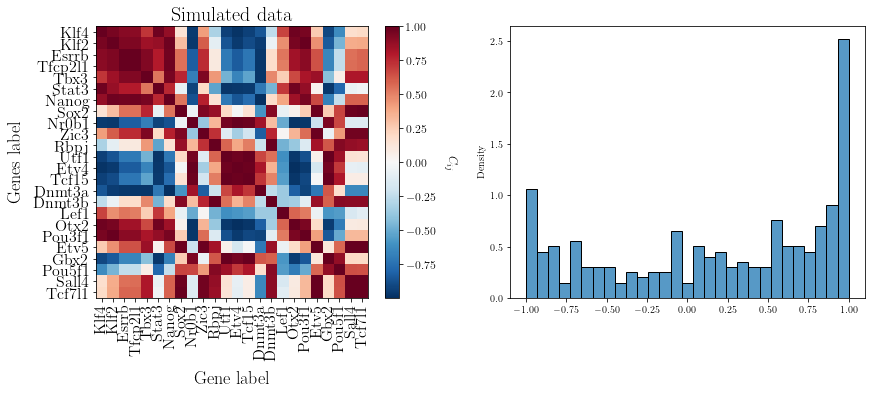

In [39]:
cm_sim = np.zeros((df_sim.shape[0], df_sim.shape[0], df_sim.shape[2]))
for ii in range(df_sim.shape[2]):
    cm_sim[:,:, ii] = np.corrcoef(df_sim[:,:,ii])
cm_sim_SCODE_PST_MB_lN_Cont = np.mean(cm_sim, axis=2)

bins = np.linspace(-1, 1, 30)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
figfunc.plotmat(cm_sim_SCODE_PST_MB_lN_Cont, fig, ax[0], genes_order, "Simulated data")
sns.histplot(np.ndarray.flatten(cm_sim_SCODE_PST_MB_lN_Cont), bins=bins,  ax=ax[1], stat="density")
plt.show()

# # plt.imshow(np.corrcoef(spins_new_lN))
# print(np.where(spins_sim==float("nan")))



## Original CM

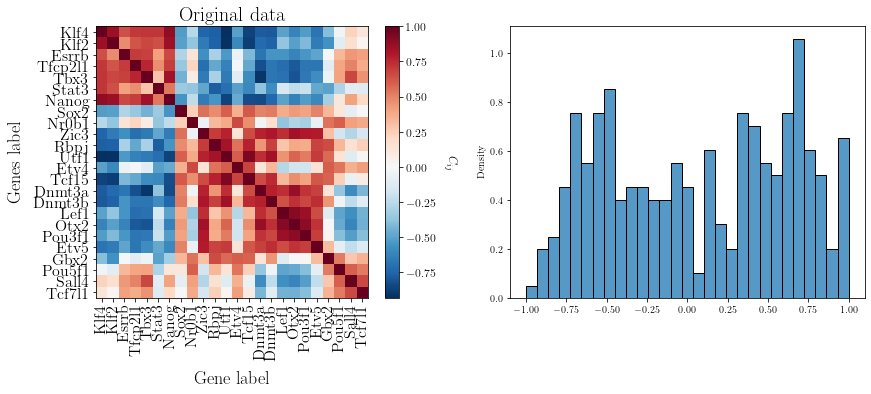

In [40]:
cm_pst_mb_psiNorm = np.corrcoef(data_LN)

bins = np.linspace(-1, 1, 30)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
figfunc.plotmat(cm_pst_mb_psiNorm, fig, ax[0], genes_order, "Original data")
sns.histplot(np.ndarray.flatten(cm_pst_mb_psiNorm), bins=bins,  ax=ax[1], stat="density")
plt.show()

### Distance

In [41]:
def sum_squared_abs_diff(array1, array2):
    diff = (array1.flatten()-array2.flatten())**2
    return np.sqrt(np.sum(diff))

In [42]:
N_rows = data_LN.shape[0]
N_cols = data_LN.shape[1]
Ntest=500
# Linearize
val_rnd = np.reshape(np.array(data_LN), (N_cols*N_rows))

# reshuflle for Ntest times
df_pN_mb_pst_shuffle = np.zeros((Ntest, N_rows, N_cols))

for ii in range(Ntest):
    np.random.seed(1234+ii)
    # Random reshuffle of the binnarized GE data
    np.random.shuffle(val_rnd)
    val_rnd_matx = val_rnd.reshape(N_rows,N_cols) ########################
    trial_long = pd.DataFrame(val_rnd_matx)

    # Save the shuffled DataFrame
    df_pN_mb_pst_shuffle[ii,:,:] = trial_long

corr_matxs_rnd = np.array([np.corrcoef(df_pN_mb_pst_shuffle[i,:,:]) for i in range(Ntest)])


In [43]:
noise_dist = [sum_squared_abs_diff(cm_pst_mb_psiNorm, corr_matxs_rnd[i,:,:]) for i in range(Ntest)]

noise_dist = np.mean(noise_dist)

result_SO = sum_squared_abs_diff(cm_pst_mb_psiNorm, cm_sim_SCODE_PST_MB_lN_Cont)/noise_dist
print(f"Scode - Orig {result_SO:.2f}")


Scode - Orig 1.33


In [44]:
# np.savetxt('cm_sim_SCODE_MB_LogNorm.txt', cm_sim_SCODE_PST_MB_lN_Cont)

# KO

In [45]:
def KO_comparison_ExpVsSim(lofFC_Exp, logFC_Sim, N_test=100):
    """compute the fraction of Experimental Data end Simulated data in Agreement"""
    comparison= np.array([np.sign(lofFC_Exp)*np.sign(logFC_Sim[ii,:]) for ii in range(N_test)])
#     print(np.sum([len(np.where(logFC_Sim[:,ii]==0)[0]) for ii in range(N_test)]))
    data_considered = np.array([len(np.where(comparison[ii,:]!=0)[0]) for ii in range(N_test)])
    
    in_agreement = np.array([len(np.where(comparison[ii,:]==1)[0])/data_considered[ii] for ii in range(N_test)])
    no_agreement = np.array([len(np.where(comparison[ii,:]==-1)[0])/data_considered[ii] for ii in range(N_test)])
    mean_in_agreement = np.mean(in_agreement)
    
    # Check
    check_sum = np.array([in_agreement[ii]+no_agreement[ii] for ii in range(N_test)])-1
    check = np.where(check_sum>0.001)[0]
    if check.size > 0:
        print("Error in comparison Exp and Sim")
    return(mean_in_agreement,    data_considered)


In [46]:
def KO_plotLogFC_ExpAndSim(lofFC_Exp, logFC_Sim, KO_genes_order):
    plt.figure(figsize=(18,5))
    plt.plot(lofFC_Exp, 
             "o",ms = 10, label="Exp")
    plt.plot(logFC_Sim[:,0],  
             "o", ms = 10,
             color="darkred", label= "Sim")
    plt.xticks(np.arange(0,23),KO_genes_order)
    plt.axhline(0)
    plt.legend()

## Rbpj

In [47]:
# get the initial gene expression and the KO interaction matrix to simulate the KO data
KO_gene = "Rbpj"
KO_gene_idk = np.where(genes_order ==KO_gene)[0][0]

# KO_lN_rec_matx = np.delete(lN_rec_matx, KO_gene_idk, axis=0)
KO_lN_rec_matx = np.delete(A_tot, KO_gene_idk, axis=0)
KO_lN_rec_matx = np.delete(KO_lN_rec_matx, KO_gene_idk, axis=1)

KO_genes_order = np.delete(genes_order, KO_gene_idk, axis=0)

KO_result = result.drop(KO_gene)
KO_result.to_csv(path_data+"OUT_SCODE_LN/KO_LN/RBPJ/initial_GE_LogNorm_MB_KO.txt", sep='\t', index=False, header=False)

np.savetxt(path_data+ "OUT_SCODE_LN/KO_LN/RBPJ/A_KO_LogNorm_MB.txt",KO_lN_rec_matx)

KO_R_wt_avg = np.delete(np.array(df_sim_avg),KO_gene_idk, axis=0)
KO_R_wt_std = np.delete(np.array(df_sim_std),KO_gene_idk, axis=0)


In [48]:
compute = False
N_sim=500
KO_df_sim = np.zeros((len(KO_genes_order), 101, N_sim))

for ii in range(N_sim):
    if ii%50==0:
        print("Exp ", ii)
    out_sim = "/Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_LN/KO_LN/RBPJ/OUT/out_simSCODE_LogNorm_MB_"+str(ii)+".txt"
    
    if compute == True:
        # call R script Reconstruct_dynamics.R
        ! Rscript /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/CODE/Reconstruct_dynamics.R /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_LN/KO_LN/RBPJ/initial_GE_LogNorm_MB_KO.txt /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_LN/KO_LN/RBPJ/A_KO_LogNorm_MB.txt {out_sim} {23}

    # load simulated data
    KO_df_sim[:,:,ii] = pd.read_table(path_data+"OUT_SCODE_LN/KO_LN/RBPJ/OUT/out_simSCODE_LogNorm_MB_"+str(ii)+".txt", delimiter="\t", dtype={"Value": float}).set_index(KO_genes_order)
    KO_df_sim[KO_df_sim<0]=0
    

Exp  0
Exp  50
Exp  100
Exp  150
Exp  200
Exp  250
Exp  300
Exp  350
Exp  400
Exp  450


index of genes not significantly different (2,)


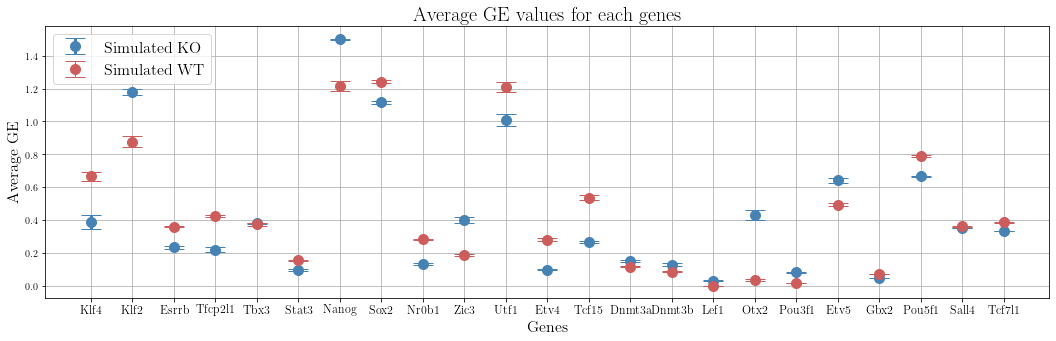

In [49]:
# compute the average and std of the simulated  KO data
KO_R_df_sim_avg, KO_R_df_sim_std = funcs_ko.WT_avg_w(KO_df_sim)
KO_R_df_sim_std = (np.std(KO_df_sim, axis=1)/np.sqrt(KO_df_sim.shape[1]))[:,0]

KO_R_diff, KO_R_diff_std, KO_R_idx_notS = funcs_ko.KO_diff_sim(KO_R_df_sim_avg, KO_R_df_sim_std ,KO_R_wt_avg, KO_R_wt_std, thr_significance=3)
# print("differences in the simulated data", KO_R_diff)
# print("error in the simulated data", KO_R_diff_std)
print("index of genes not significantly different", KO_R_idx_notS.shape)

funcs_ko.KO_plots_avgAct_SCODE(KO_R_df_sim_avg, KO_R_df_sim_std, KO_R_wt_avg, KO_R_wt_std, KO_genes_order, N_sigma=1)

[ 4 21]
KO_std-wt_std not significant for gene  ['Tbx3' 'Sall4'] [ 4 21]
in agreement 0.16666666666666666
data considered 6
considered genes ['Klf4' 'Esrrb' 'Tfcp2l1' 'Nanog' 'Dnmt3b' 'Lef1']


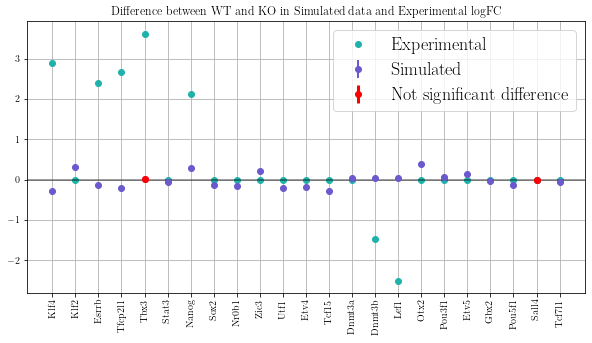

In [50]:
logFC_Leeb_R = np.delete(np.array(df_KO_N24_Leeb_cl[KO_gene]), KO_gene_idk) # logFC Leeb


in_agreement_lN_R, data_considered_lN_R, considered_genes_lN_R = funcs_ko.KO_diff_ExpVsSim(logFC_Leeb_R, KO_R_diff, KO_R_diff_std, KO_genes_order)
print("in agreement", in_agreement_lN_R)
print("data considered", data_considered_lN_R)
print("considered genes", considered_genes_lN_R)

funcs_ko.KO_plof_Diff_LogFC(logFC_Leeb_R, KO_R_diff, KO_R_diff_std, KO_genes_order, KO_R_idx_notS, 'Difference between WT and KO in Simulated data and Experimental logFC')


## Etv5

In [51]:
KO_gene = "Etv5"
KO_gene_idk = np.where(genes_order ==KO_gene)[0][0]

# KO_lN_rec_matx = np.delete(lN_rec_matx, KO_gene_idk, axis=0)
KO_lN_rec_matx = np.delete(A_tot, KO_gene_idk, axis=0)
KO_lN_rec_matx = np.delete(KO_lN_rec_matx, KO_gene_idk, axis=1)

KO_genes_order = np.delete(genes_order, KO_gene_idk, axis=0)

KO_result = result.drop(KO_gene)
KO_result.to_csv(path_data+"OUT_SCODE_LN/KO_LN/ETV5/initial_GE_LogNorm_MB_KO.txt", sep='\t', index=False, header=False)

np.savetxt(path_data+ "OUT_SCODE_LN/KO_LN/ETV5/A_KO_LogNorm_MB.txt",KO_lN_rec_matx)

KO_E_wt_avg = np.delete(np.array(df_sim_avg),KO_gene_idk, axis=0)
KO_E_wt_std = np.delete(np.array(df_sim_std),KO_gene_idk, axis=0)


In [52]:
compute = False
N_sim=500
KO_df_sim = np.zeros((len(KO_genes_order), 101, N_sim))

for ii in range(N_sim):
    if ii%50==0:
        print("Exp ", ii)
    out_sim = "/Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_LN/KO_LN/ETV5/OUT/out_simSCODE_LogNorm_MB_"+str(ii)+".txt"
    
    if compute == True:
        # call R script Reconstruct_dynamics.R
        ! Rscript /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/CODE/Reconstruct_dynamics.R /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_LN/KO_LN/ETV5/initial_GE_LogNorm_MB_KO.txt /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_LN/KO_LN/ETV5/A_KO_LogNorm_MB.txt {out_sim} {23}

    # load simulated data
    KO_df_sim[:,:,ii] = pd.read_table(path_data+"OUT_SCODE_LN/KO_LN/ETV5/OUT/out_simSCODE_LogNorm_MB_"+str(ii)+".txt", delimiter="\t", dtype={"Value": float}).set_index(KO_genes_order)
    KO_df_sim[KO_df_sim<0]=0
    

Exp  0
Exp  50
Exp  100
Exp  150
Exp  200
Exp  250
Exp  300
Exp  350
Exp  400
Exp  450


index of genes not significantly different (8,)


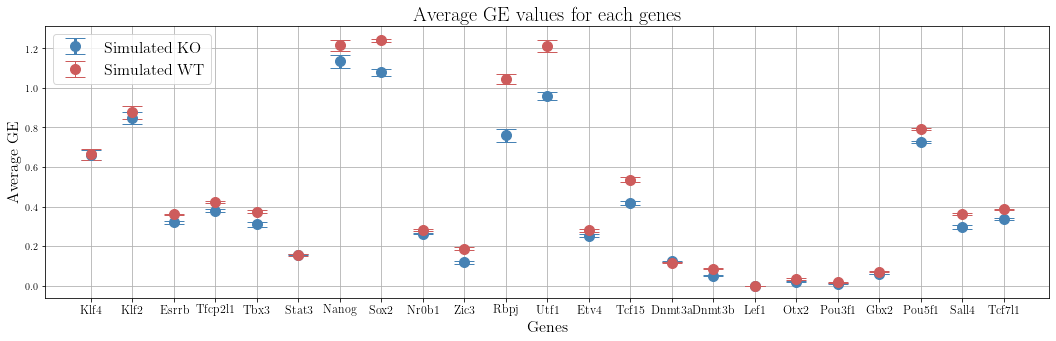

In [53]:
# compute the average and std of the simulated  KO data
KO_E_df_sim_avg, KO_E_df_sim_std = funcs_ko.WT_avg_w(KO_df_sim)
KO_E_df_sim_std = (np.std(KO_df_sim, axis=1)/np.sqrt(KO_df_sim.shape[1]))[:,0]


KO_E_diff, KO_E_diff_std, KO_E_idx_notS = funcs_ko.KO_diff_sim(KO_E_df_sim_avg, KO_E_df_sim_std ,KO_E_wt_avg, KO_E_wt_std, thr_significance=3)

print("index of genes not significantly different", KO_E_idx_notS.shape)

funcs_ko.KO_plots_avgAct_SCODE(KO_E_df_sim_avg, KO_E_df_sim_std, KO_E_wt_avg, KO_E_wt_std, KO_genes_order, N_sigma=1)

[ 0  1  5  6 12 14 16 17]
KO_std-wt_std not significant for gene  ['Klf4' 'Klf2' 'Stat3' 'Nanog' 'Etv4' 'Dnmt3a' 'Lef1' 'Otx2'] [ 0  1  5  6 12 14 16 17]
in agreement 0.25
data considered 4
considered genes ['Esrrb' 'Tfcp2l1' 'Tbx3' 'Dnmt3b']


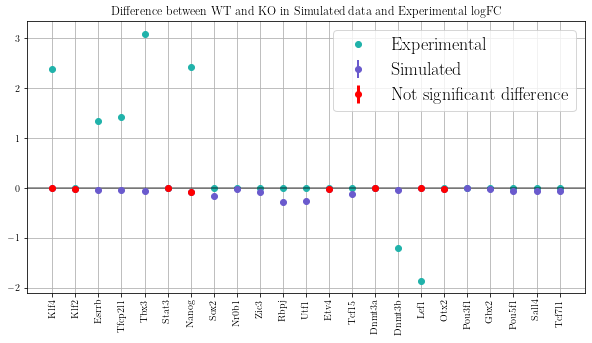

In [54]:
logFC_Leeb_E = np.delete(np.array(df_KO_N24_Leeb_cl[KO_gene]), KO_gene_idk) # logFC Leeb


in_agreement_lN_E, data_considered_lN_E, considered_genes_lN_E = funcs_ko.KO_diff_ExpVsSim(logFC_Leeb_E, KO_E_diff, KO_E_diff_std, KO_genes_order)
print("in agreement", in_agreement_lN_E)
print("data considered", data_considered_lN_E)
print("considered genes", considered_genes_lN_E)

funcs_ko.KO_plof_Diff_LogFC(logFC_Leeb_E, KO_E_diff, KO_E_diff_std, KO_genes_order, KO_E_idx_notS, 'Difference between WT and KO in Simulated data and Experimental logFC')


## Tcf7l1

In [55]:
KO_gene = "Tcf7l1"
KO_gene_idk = np.where(genes_order ==KO_gene)[0][0]

# KO_lN_rec_matx = np.delete(lN_rec_matx, KO_gene_idk, axis=0)
KO_lN_rec_matx = np.delete(A_tot, KO_gene_idk, axis=0)
KO_lN_rec_matx = np.delete(KO_lN_rec_matx, KO_gene_idk, axis=1)

KO_genes_order = np.delete(genes_order, KO_gene_idk, axis=0)

KO_result = result.drop(KO_gene)
KO_result.to_csv(path_data+"OUT_SCODE_LN/KO_LN/TCF7L1/initial_GE_LogNorm_MB_KO.txt", sep='\t', index=False, header=False)

np.savetxt(path_data+ "OUT_SCODE_LN/KO_LN/TCF7L1/A_KO_LogNorm_MB.txt",KO_lN_rec_matx)

KO_T_wt_avg = np.delete(np.array(df_sim_avg),KO_gene_idk, axis=0)
KO_T_wt_std = np.delete(np.array(df_sim_std),KO_gene_idk, axis=0)


In [56]:
compute = False
N_sim=500
KO_df_sim = np.zeros((len(KO_genes_order), 101, N_sim))

for ii in range(N_sim):
    if ii%50==0:
        print("Exp ", ii)
    out_sim = "/Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_LN/KO_LN/TCF7L1/OUT/out_simSCODE_LogNorm_MB_"+str(ii)+".txt"
    
    if compute==True:
        # call R script Reconstruct_dynamics.R
        ! Rscript /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/CODE/Reconstruct_dynamics.R /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_LN/KO_LN/TCF7L1/initial_GE_LogNorm_MB_KO.txt /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_LN/KO_LN/TCF7L1/A_KO_LogNorm_MB.txt {out_sim} {23}

    # load simulated data
    KO_df_sim[:,:,ii] = pd.read_table(path_data+"OUT_SCODE_LN/KO_LN/TCF7L1/OUT/out_simSCODE_LogNorm_MB_"+str(ii)+".txt", delimiter="\t", dtype={"Value": float}).set_index(KO_genes_order)
    KO_df_sim[KO_df_sim<0]=0
    

Exp  0
Exp  50
Exp  100
Exp  150
Exp  200
Exp  250
Exp  300
Exp  350
Exp  400
Exp  450


index of genes not significantly different (13,)


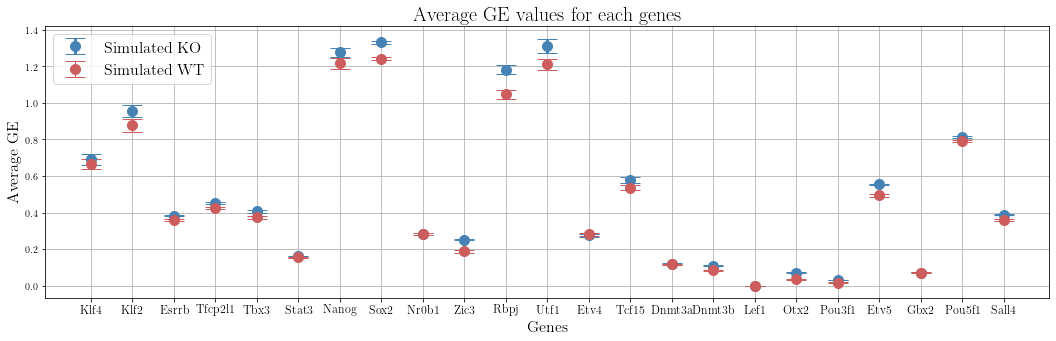

In [57]:
# compute the average and std of the simulated  KO data
KO_T_df_sim_avg, KO_T_df_sim_std = funcs_ko.WT_avg_w(KO_df_sim)
KO_T_df_sim_std = (np.std(KO_df_sim, axis=1)/np.sqrt(KO_df_sim.shape[1]))[:,0]

KO_T_diff, KO_T_diff_std, KO_T_idx_notS = funcs_ko.KO_diff_sim(KO_T_df_sim_avg, KO_T_df_sim_std ,KO_T_wt_avg, KO_T_wt_std, thr_significance=3)

print("index of genes not significantly different", KO_T_idx_notS.shape)

funcs_ko.KO_plots_avgAct_SCODE(KO_T_df_sim_avg, KO_T_df_sim_std, KO_T_wt_avg, KO_T_wt_std, KO_genes_order, N_sigma=1)

[ 0  1  4  5  6  8 11 12 13 14 16 20 21]
KO_std-wt_std not significant for gene  ['Klf4' 'Klf2' 'Tbx3' 'Stat3' 'Nanog' 'Nr0b1' 'Utf1' 'Etv4' 'Tcf15'
 'Dnmt3a' 'Lef1' 'Gbx2' 'Pou5f1'] [ 0  1  4  5  6  8 11 12 13 14 16 20 21]
in agreement 1.0
data considered 2
considered genes ['Esrrb' 'Tfcp2l1']


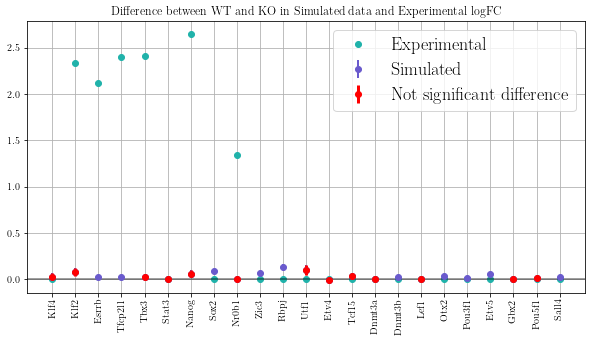

In [58]:
logFC_Leeb_T = np.delete(np.array(df_KO_N24_Leeb_cl[KO_gene]), KO_gene_idk) # logFC Leeb


in_agreement_lN_T, data_considered_lN_T, considered_genes_lN_T = funcs_ko.KO_diff_ExpVsSim(logFC_Leeb_T, KO_T_diff, KO_T_diff_std, KO_genes_order)
print("in agreement", in_agreement_lN_T)
print("data considered", data_considered_lN_T)
print("considered genes", considered_genes_lN_T)

funcs_ko.KO_plof_Diff_LogFC(logFC_Leeb_T, KO_T_diff, KO_T_diff_std, KO_genes_order, KO_T_idx_notS, 'Difference between WT and KO in Simulated data and Experimental logFC')


# Three KO

In [59]:
KO_gene = ["Rbpj", "Etv5", "Tcf7l1"]
KO_gene_idk = [np.where(genes_order == KO_gene[i])[0][0]  for i in range(len(KO_gene))]


KO_lN_rec_matx = np.delete(A_tot, KO_gene_idk, axis=0)
KO_lN_rec_matx = np.delete(KO_lN_rec_matx, KO_gene_idk, axis=1)

KO_genes_order = np.delete(genes_order, KO_gene_idk, axis=0)

KO_result = result.drop(KO_gene)
KO_result.to_csv(path_data+"OUT_SCODE_LN/KO_LN/MULT/initial_GE_PsiNorm_MB_KO.txt", sep='\t', index=False, header=False)

np.savetxt(path_data+ "OUT_SCODE_LN/KO_LN/MULT/A_KO_PsiNorm_MB.txt",KO_lN_rec_matx)

KO_Th_wt_avg = np.delete(np.array(df_sim_avg),KO_gene_idk, axis=0)
KO_Th_wt_std = np.delete(np.array(df_sim_std),KO_gene_idk, axis=0)

In [60]:
compute = False
N_sim=500
KO_df_sim = np.zeros((len(KO_genes_order), 101, N_sim))
for ii in range(N_sim):
    if ii%50==0:
        print("Exp ", ii)
    out_sim = "/Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_LN/KO_LN/MULT/OUT/out_simSCODE_LogNorm_MB_"+str(ii)+".txt"

    if compute==True:
        # call R script Reconstruct_dynamics.R
        ! Rscript /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/GRN_Inference_CODE/Reconstruct_dynamics.R /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_LN/KO_LN/MULT/initial_GE_LogNorm_MB_KO.txt /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_LN/KO_LN/MULT/A_KO_LogNorm_MB.txt {out_sim} {21}

    # load simulated data
    KO_df_sim[:,:,ii] = pd.read_table(path_data+"OUT_SCODE_LN/KO_LN/MULT/OUT/out_simSCODE_LogNorm_MB_"+str(ii)+".txt", delimiter="\t", dtype={"Value": float}).set_index(KO_genes_order)
    KO_df_sim[KO_df_sim<0]=0
    


Exp  0
Exp  50
Exp  100
Exp  150
Exp  200
Exp  250
Exp  300
Exp  350
Exp  400
Exp  450


In [61]:
# compute the average and std of the simulated  KO data
KO_Th_df_sim_avg, KO_Th_df_sim_std = funcs_ko.WT_avg_w(KO_df_sim)
KO_Th_df_sim_std = (np.std(KO_df_sim, axis=1)/np.sqrt(KO_df_sim.shape[1]))[:,0]


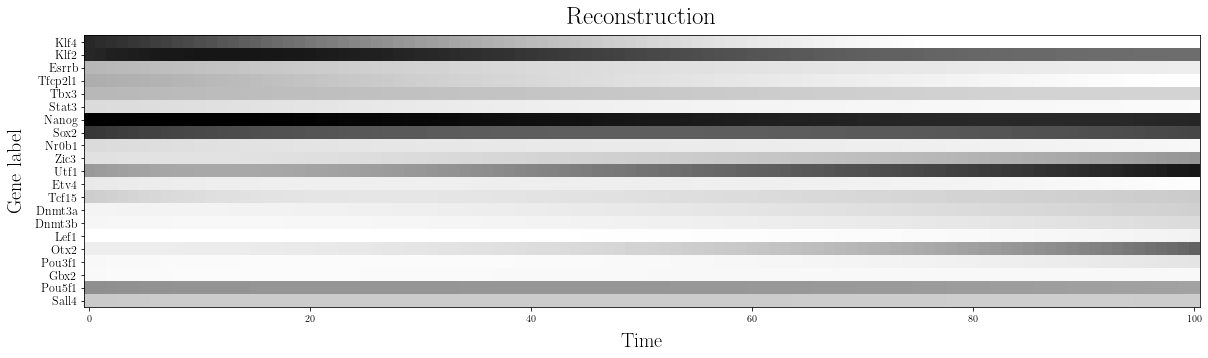

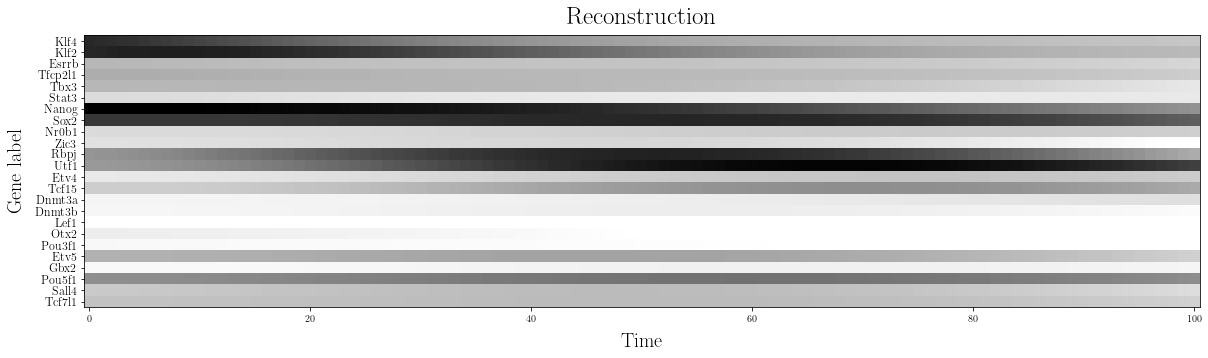

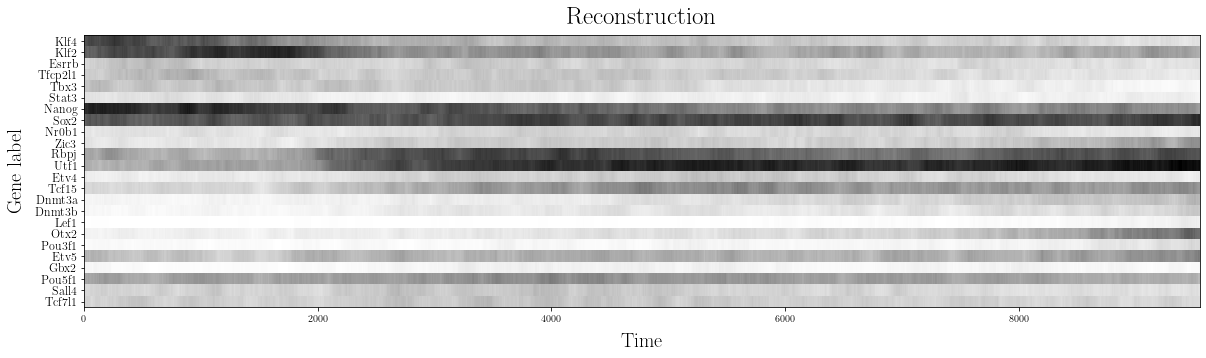

In [62]:
fun_plotting.raster_plot(KO_df_sim[:,:,0], 'Reconstruction', 1, KO_genes_order)
plt.show()

fun_plotting.raster_plot(df_sim[:,:,0], 'Reconstruction', 1, genes_order)
plt.show()

fun_plotting.raster_plot(np.array(df_lN_mb_pst), 'Reconstruction', 1, genes_order)
plt.show()

index of genes not significantly different []
number of genes significantly different (21,)
['Klf4' 'Klf2' 'Esrrb' 'Tfcp2l1' 'Tbx3' 'Stat3' 'Nanog' 'Sox2' 'Nr0b1'
 'Zic3' 'Utf1' 'Etv4' 'Tcf15' 'Dnmt3a' 'Dnmt3b' 'Lef1' 'Otx2' 'Pou3f1'
 'Gbx2' 'Pou5f1' 'Sall4']


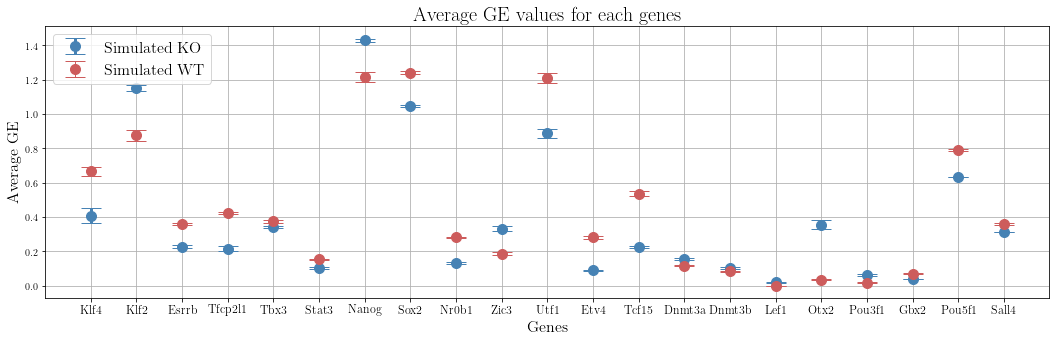

In [63]:
# compute the average and std of the simulated  KO data
KO_Th_df_sim_avg, KO_Th_df_sim_std = funcs_ko.WT_avg_w(KO_df_sim)
KO_Th_df_sim_std = (np.std(KO_df_sim, axis=1)/np.sqrt(KO_df_sim.shape[1]))[:,0]

KO_Th_diff, KO_Th_diff_std, KO_Th_idx_notS = funcs_ko.KO_diff_sim(KO_Th_df_sim_avg, KO_Th_df_sim_std ,KO_Th_wt_avg, KO_Th_wt_std, thr_significance=3)
# KO_Th_genes_order_sel = KO_genes_order[KO_Th_idx_notS]
if KO_Th_idx_notS.shape[0] == 0:
    KO_Th_genes_order_sel = KO_genes_order
else:
    # print("index of genes not significantly different", KO_Th_idx_notS)
    KO_Th_genes_order_sel = np.delete(KO_genes_order, KO_Th_idx_notS, axis=0)

print("index of genes not significantly different", KO_Th_idx_notS)
print("number of genes significantly different", KO_Th_genes_order_sel.shape)
# print(KO_genes_order)
print(KO_Th_genes_order_sel)

funcs_ko.KO_plots_avgAct_SCODE(KO_Th_df_sim_avg, KO_Th_df_sim_std, KO_Th_wt_avg, KO_Th_wt_std, KO_genes_order, N_sigma=1)



number of experimental data, no KO (17, 1)


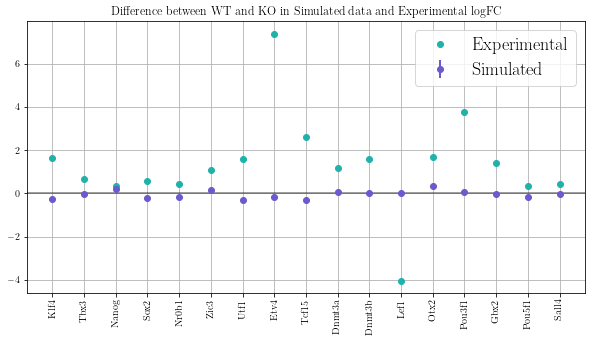

In [64]:
# exp logFC
df_tKO_Kalkan = pd.read_csv(path_data+'Kalkan_Data/df_tripleKO.csv', index_col=0, header=0)

# # remove row of the KO
df_tKO_Kalkan_sel = df_tKO_Kalkan.drop(["Etv5", "Tcf7l1"])
print("number of experimental data, no KO",df_tKO_Kalkan_sel.shape)

# select only the genes present in df_tKO_Kalkan_sel
KO_Th_diff_temp = KO_Th_diff[np.array([x for x in range(len(KO_genes_order)) if KO_genes_order[x] in df_tKO_Kalkan_sel.index])]
KO_Th_diff_std_temp = KO_Th_diff_std[np.array([x for x in range(len(KO_genes_order)) if KO_genes_order[x] in df_tKO_Kalkan_sel.index])]
KO_genes_order_temp = np.array([x for x in KO_genes_order if x in df_tKO_Kalkan_sel.index])
KO_genes_order_temp_idx = np.array([x for x in range(len(KO_genes_order)) if KO_genes_order[x] in df_tKO_Kalkan_sel.index])

funcs_ko.KO_plof_Diff_LogFC(df_tKO_Kalkan_sel, KO_Th_diff_temp, KO_Th_diff_std_temp, KO_genes_order_temp, [], 'Difference between WT and KO in Simulated data and Experimental logFC')
if KO_Th_idx_notS.shape[0] != 0:
    KO_Th_diff = np.delete(KO_Th_diff, KO_Th_idx_notS, axis=0)
    KO_Th_diff_std = np.delete(KO_Th_diff_std, KO_Th_idx_notS, axis=0)
# search gene present in genes_order and absent in df_tKO_Kalkan
common_genes = np.array([x for x in KO_Th_genes_order_sel if x in df_tKO_Kalkan_sel.index])

# indices of genes_order corresponding to common_genes
common_genes_idx = np.array([x for x in range(len(KO_Th_genes_order_sel)) if KO_Th_genes_order_sel[x] in df_tKO_Kalkan_sel.index])

# select only simulated KO and WT for which we know experimental tKO
# differences for the considered genes
KO_Th_diff_sel = KO_Th_diff[common_genes_idx]
KO_Th_diff_std_sel = KO_Th_diff_std[common_genes_idx]

df_tKO_Kalkan_sel = df_tKO_Kalkan_sel.loc[common_genes]
df_tKO_Kalkan_sel = np.squeeze(np.array(df_tKO_Kalkan_sel.iloc[:,0]))